In [1]:
#def xop2_2d(g, f, a0, a):
from tqdm import tqdm
from tools.operators import xop_2d, yop_2d, Discrete1DGrid, RHSswe, RK3, initialize_vortex
from tools.plotting import VisualizeGrid, coLocateVelocity, StartPlot, UpdatePlot, StartPlotEnergy, UpdatePlotEnergy
from tools.tests import StabilityCheck, calc_diagnostics
import numpy as np
from matplotlib import pyplot as plt
import time

### Soliton Domain
0 <= x <= 3600000, 0 <= y <= 2800000 <br>
Coriolis: f = f0 + B(y-y0) <br>
f0 = 7.27e-5
B=1.97e-11
y0=1400000
depth: H = 600 <br>
gravity: g = .02 <br>
tfinal: 10*365*24*3600

visc = 250
bottom drag = 1e-7

#### First Geometry - 80km resolution

In [2]:
#basin, resolution
xmin,xmax,N = 0, 3600000, 180
ymin,ymax,M = 0, 2800000, 140

# discretize x-y directions on a C-grid
xe,xc,dx = Discrete1DGrid(xmin,xmax,N)
ye,yc,dy = Discrete1DGrid(ymin,ymax,M)
xp,yp = np.meshgrid(xc,yc) # p-points
xu,yu = np.meshgrid(xe,yc) # u-points
xv,yv = np.meshgrid(xc,ye) # v-points
xz,yz = np.meshgrid(xe,ye) # z-points (vorticity)
dxs = np.array([dx,dy])    # grid size
# VisualizeGrid(xu,yu,xv,yv,xp,yp,xz,yz) # visualize grid optional
f0 = 7.27e-5
B = 1.97e-11
gravity = 0.02
depth = np.ones([M,N])*600
coriolis = f0 + B*(yz-1400000)

In [3]:
%matplotlib

Using matplotlib backend: <object object at 0x0000027E7FF5A220>


In [15]:
plt.close('all')

### initial conditions


In [5]:
u = np.zeros_like(xu)
v = np.zeros_like(xv)
p = np.zeros_like(xp)

In [6]:
#put tau_x on u-points!
L = 2800000
alph = .13
tau0 = -5e-5

first_term = (1+4*alph*(yu/L - 1/2)) * np.cos((2*np.pi*yu)/L)
second_term = ((4*alph)/(2*np.pi)) * np.sin((2*np.pi*yu)/L)

tau_x = tau0 * (first_term-second_term)

In [7]:
10*365*24*3600

315360000

In [8]:
periodic = False

alin = 1 # toggles between linear (0), nonlinear (1) PDEs
visc = 250
bottom_drag = 1e-7
# tolerance = 10**-5
cell_area = dx*dy
ntimesteps = 10*365*24*2 #daily = 10*365
isnap = 10       # frequency of visualization
finaltime = 10*365*24*3600
dt = finaltime/ntimesteps
StabilityCheck(gravity,depth,dt,dx)

max. Courant number: 0.31176914536239786
Stable gravity wave time step:


In [9]:
#reset indices for diagnostic calculations depending on BCs
if periodic:
    ind1u,ind2u = 1,-1
    ind1v,ind2v = 1,-1
    ind1p,ind2p = 1,-1
    ind1z,ind2z = 1,-1
else:
    ind1u, ind2u = 0, len(u[0,])
    ind1v ,ind2v = 0, len(v[0,])
    ind1p ,ind2p = 0, len(p[0,])
    ind1z ,ind2z = 0, len(coriolis[0,])

In [10]:
initial_energy, initial_enstrophy, initial_mass = calc_diagnostics(u[:,ind1u:ind2u],v[:,ind1v:ind2v],p[:,ind1p:ind2p],dxs,depth[:,ind1p:ind2p],gravity,coriolis[:,ind1z:ind2z],alin)

### ADJUST P LEVS FOR PRESSURE CONTOURS


In [11]:
#set pmin manually since it drops slightly from beginning
plevs=np.linspace(-250,250,101)
xas,yas=4,4

In [12]:
fig,ax,pcont,arrows = StartPlot(u,v,p,xe,xc,ye,yc,plevs,XarrowStep=xas,YarrowStep=yas,arrow_scale=4 ,colormap='seismic')
plt.show()

In [13]:
total_system_energy = [initial_energy]
total_system_enstrophy = [initial_enstrophy]
total_system_mass = [initial_mass]
times = [0.0]
savep = []
saveu = []
savev = []

In [14]:
for it in tqdm(range(ntimesteps)):
    timeCurrent = it*dt
    RK3(u,v,p,depth, coriolis, gravity,
        dxs, dt, timeCurrent, visc,
        bdc=bottom_drag, tau_x = tau_x, tau_y=0,
        alin=alin,
        periodic=periodic)
    if (it+1)%25000 == 0:
        savep.append(p)
        saveu.append(u)
        savev.append(v)
    
    if (it+1)%isnap==0:
        time.sleep(0.01)
        pcont = UpdatePlot(u,v,p,xe,xc,ye,yc,ax,pcont,plevs,timeCurrent+dt,arrows,XarrowStep=xas,YarrowStep=yas,colormap='seismic') # update numerical plot

        times.append(timeCurrent)
        eg, es, ms = calc_diagnostics(u[:,ind1u:ind2u],v[:,ind1v:ind2v],p[:,ind1p:ind2p],dxs,depth[:,ind1p:ind2p],gravity,coriolis[:,ind1z:ind2z],alin)
        total_system_energy.append(eg)
        total_system_enstrophy.append(es)
        total_system_mass.append(ms)

 13%|█████████▊                                                                 | 22900/175200 [06:46<48:40, 52.15it/s]Exception in Tkinter callback
Traceback (most recent call last):
  File "C:\Users\mdona\anaconda3\lib\tkinter\__init__.py", line 1892, in __call__
    return self.func(*args)
  File "C:\Users\mdona\anaconda3\lib\tkinter\__init__.py", line 814, in callit
    func(*args)
  File "C:\Users\mdona\anaconda3\lib\site-packages\matplotlib\backends\_backend_tk.py", line 271, in idle_draw
    self.draw()
  File "C:\Users\mdona\anaconda3\lib\site-packages\matplotlib\backends\backend_tkagg.py", line 10, in draw
    super().draw()
  File "C:\Users\mdona\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py", line 387, in draw
    self.figure.draw(self.renderer)
  File "C:\Users\mdona\anaconda3\lib\site-packages\matplotlib\artist.py", line 95, in draw_wrapper
    result = draw(artist, renderer, *args, **kwargs)
  File "C:\Users\mdona\anaconda3\lib\site-packages\matplotlib\ar

Traceback (most recent call last):
  File "C:\Users\mdona\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3457, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\mdona\AppData\Local\Temp\ipykernel_8904\651733825.py", line 15, in <module>
    pcont = UpdatePlot(u,v,p,xe,xc,ye,yc,ax,pcont,plevs,timeCurrent+dt,arrows,XarrowStep=xas,YarrowStep=yas,colormap='seismic') # update numerical plot
  File "C:\Users\mdona\OneDrive\Miami Stuff\fluid_code_2\tools\plotting.py", line 86, in UpdatePlot
    plt.pause(1.e-2)
  File "C:\Users\mdona\anaconda3\lib\site-packages\matplotlib\pyplot.py", line 754, in pause
    canvas.draw_idle()
  File "C:\Users\mdona\anaconda3\lib\site-packages\matplotlib\backends\_backend_tk.py", line 275, in draw_idle
    self._idle_draw_id = self._tkcanvas.after_idle(idle_draw)
  File "C:\Users\mdona\anaconda3\lib\tkinter\__init__.py", line 830, in after_idle
    return self.after('idle', func, *args)
  File "C:\Users\mdon

TypeError: object of type 'NoneType' has no len()

In [15]:
plt.close('all')

In [16]:
%matplotlib inline

In [18]:
mass_plot = (np.array(total_system_mass)+1)/(initial_mass+1)
energy_plot = (np.array(total_system_energy)+1)/(initial_energy+1)
enstrophy_plot = (np.array(total_system_enstrophy) + 1)/(initial_enstrophy+1)

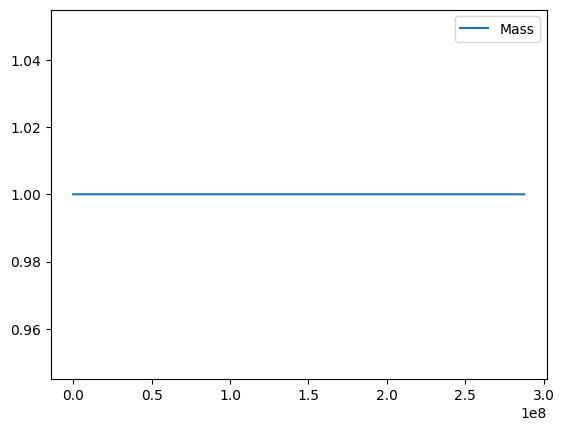

In [21]:
plt.plot(times,mass_plot, label='Mass')
# plt.plot(times,energy_plot, label='Energy')
# plt.plot(times,enstrophy_plot, label='Enstrophy')
plt.legend()
plt.show()